# [George McNinch](http://gmcninch.math.tufts.edu) Math 87 - Spring 2026

# Week 5
# Network flows and linear programming 


So far we have looked at a few examples of linear programs. The key step in modeling these
problems is to write down the program itself.

As we saw, for simple programs, such as the carpenter problem, we can figure it out geometrically.
There were only a few variables and a few obvious constraints and it was easy to check all the
vertices.

Let's consider a more complex problem.


# Network flows

We are going to consider some more complex situations for which we will
use a *network flow* to help produce the corresponding linear program.

Let's recall that a *directed graph* is a pair $G = (V,E)$ where the
elements of the set $V$ are the *vertices* of the graph, and where
$E ⊂ V × V$ are the *edges* of $G$. Thus, an element $e = (a,b) ∈ E$
represents a directed edge from vertex $a$ to vertex $b$.

We can produce diagrams for directed graphs using the program
[`graphviz`](https://graphviz.org/) (and a corresponding python library
[`python-graphviz`](https://github.com/xflr6/graphviz)).

## Installing graphviz

You can install graphviz using:
```bash
pip install graphviz
```

In Google Colab, you may also need to install the graphviz system package:
```python
!apt-get install graphviz
```

Let's look at a simple graph:

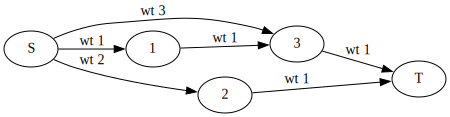

In [1]:
from graphviz import Digraph as GVDigraph

dot = GVDigraph("example")
dot.attr(rankdir='LR')

# vertices are just labeled by a string
vertices = ['S', '1', '2', '3', 'T']

# edges join two vertices, and have an attached numerical *weight*
edges = [{ 'from': 'S', 'to': '1', 'weight': 1 },
         { 'from': 'S', 'to': '2', 'weight': 2 },
         { 'from': '1', 'to': '3', 'weight': 1 },
         { 'from': 'S', 'to': '3', 'weight': 3 },
         { 'from': '2', 'to': 'T', 'weight': 1, 'lower': 10 },
         { 'from': '3', 'to': 'T', 'weight': 1, 'lower': 9 }
        ]

for v in vertices:
    dot.node(v)
  
for e in edges:
    dot.edge(e["from"], e["to"], label=f"wt {e['weight']}")
  
dot

## Understanding Network Flows

We view each edge as a *variable* (*"what quantity flows through this edge?"*).

The weights determine the linear function to be *optimized*; we represent this linear
function as a (row) vector `c`, the *objective vector*.

Each *internal vertex* determines a **conservation law**: at each internal vertex, the sum of the value of the incoming variables must be the same as the sum of the value of the outgoing variables.

## A Useful Helper Function: Standard Basis Vectors

When building constraint matrices, we often need vectors that are all zeros except for a single 1.
These are called *standard basis vectors*. Here's a helper function to create them:

**Note:** You don't have to use this function if you prefer to build your constraint matrices differently.
Some students find it helpful, others prefer to write out the matrices explicitly. Both approaches are fine!

In [5]:
import numpy as np

# Standard basis vector: creates a vector of given size with 1 at the given index
# Indices are 0-based, so sbv(0, 3) returns [1.0, 0.0, 0.0]
def sbv(index, size):
    return np.array([1.0 if i == index else 0.0 for i in range(size)])

# Example usage:
print("sbv(0, 3) =", sbv(0, 3))  # [1, 0, 0]
print("sbv(1, 3) =", sbv(1, 3))  # [0, 1, 0]
print("sbv(2, 5) =", sbv(2, 5))  # [0, 0, 1, 0, 0]

sbv(0, 3) = [1. 0. 0.]
sbv(1, 3) = [0. 1. 0.]
sbv(2, 5) = [0. 0. 1. 0. 0.]


----

Restaurant Example
------------------

Suppose that you are opening a new restaurant and need to make sure you have enough clean
tablecloths to meet expected demand in the first week. On each day, you can buy new tablecloths for `$5`. Used tablecloths can be laundered and returned the next day for `$2` or the following day for `$1`.

Your expected tablecloth demands are:

| Day                |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
| :--                | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| tablecloths needed |  10 |  10 |  15 |  20 |  40 |  40 |  30 |

Let's try to formulate a linear program to minimize the costs.

## Why use a network flow?

We could try to write constraints directly. For example:

Let's name quantities:
- $b_i$ = # tablecloths bought on day $i$
- $f_i$ = # dirty tablecloths sent to fast laundry on day $i$
- $s_i$ = # dirty tablecloths sent to slow laundry on day $i$

The constraints would be:
- Day 1: $t_1 \le b_1$
- Day 2: $t_2 \le b_2 + (b_1 - f_1 - s_1) + f_1$
- Day 3: $t_3 \le b_3 + (b_1 + b_2 - f_1 - s_1 - f_2 - s_2) + f_2 + s_1$
- etc...

This becomes increasingly hard to keep track of and formulate!

**Instead**, we build a network model and track the flow of tablecloths.


## Describing the network flow

We represent the *source* of tablecloths by a vertex.
And for each day, we form a vertex representing `clean` tablecloths, and a vertex representing
`used` tablecloths.

Remember that edges in our graph correspond to *variables*.

- For each day, we create an edge connecting the source of tablecloths with the vertex representing the `clean` tablecloths for the day. These edges represent *purchase* of tablecloths.

- For each day, we create an edge connecting vertex for the `clean` tablecloths for the day with the vertex for the `used` tablecloths for the day. These edges represent *use*, and their corresponding variables must satisfy the lower bound indicated by *expected tablecloth demand*.

- For each day (except day 7), we create an edge connecting the vertex for the `clean` tablecloths for the day with the vertex for the `clean` tablecloths of the subsequent day. These edges represent *carry-over* of unused tablecloths.

- For each day (except day 7) we create edge connecting the vertex for the `used` tablecloths for the day with the vertex for the `clean` tablecloths of the subsequent day. These edges represent use of the *fast laundry*.

- For each day (except days 6 and 7) we create edge connecting the vertex for the `used` tablecloths for the day with the vertex for the `clean` tablecloths of two days later. These edges represent use of the *slow laundry*.

Here is the code to define the graph:

In [2]:
# Usage requirements for each day
demand = {1: 10, 2: 10, 3: 15, 4: 20, 5: 40, 6: 40, 7: 30}

# Define vertices
source = ['source']
clean_vertices = [f"day {n} clean" for n in range(1, 8)]
used_vertices = [f"day {n} used" for n in range(1, 8)]

restaurant_vertices = source + clean_vertices + used_vertices

# Define edges
# 1. Purchase edges: source -> day N clean (cost $5 each)
purchase_edges = [
    {"from": 'source', "to": f"day {n} clean", "weight": 5, "label": "purchase"}
    for n in range(1, 8)
]

# 2. Carryover edges: day N clean -> day N+1 clean (no cost)
carryover_edges = [
    {"from": f"day {n} clean", "to": f"day {n+1} clean", "weight": 0, "label": "carryover"}
    for n in range(1, 7)
]

# 3. Use edges: day N clean -> day N used (no cost, but must meet demand)
use_edges = [
    {"from": f"day {n} clean", "to": f"day {n} used", "weight": 0, 
     "label": "use", "lower": demand[n]}
    for n in range(1, 8)
]

# 4. Fast laundry: day N used -> day N+1 clean (cost $2 each)
fast_laundry_edges = [
    {"from": f"day {n} used", "to": f"day {n+1} clean", "weight": 2, "label": "fast laundry"}
    for n in range(1, 7)
]

# 5. Slow laundry: day N used -> day N+2 clean (cost $1 each)
slow_laundry_edges = [
    {"from": f"day {n} used", "to": f"day {n+2} clean", "weight": 1, "label": "slow laundry"}
    for n in range(1, 6)
]

restaurant_edges = (purchase_edges + carryover_edges + use_edges + 
                   fast_laundry_edges + slow_laundry_edges)

print(f"Total edges (variables): {len(restaurant_edges)}")

Total edges (variables): 31


Let's visualize this network:

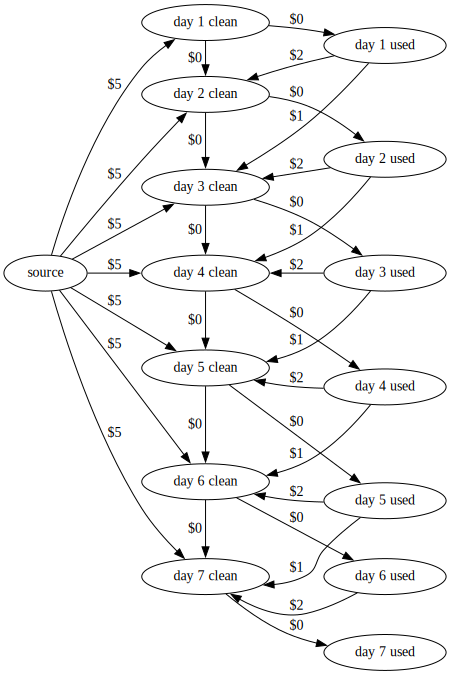

In [3]:
from graphviz import Digraph as GVDigraph

dot = GVDigraph("restaurant")
dot.attr(rankdir='LR')

# Add source
dot.node('source')

# Group clean vertices together
with dot.subgraph(name='clean') as c:
    c.attr(rank='same')
    for vertex in clean_vertices:
        c.node(vertex)

# Group used vertices together
with dot.subgraph(name='used') as c:
    c.attr(rank='same')
    for vertex in used_vertices:
        c.node(vertex)

# Add edges
for e in restaurant_edges:
    dot.edge(e["from"], e["to"], label=f"${e['weight']}")
  
dot

## Building the Linear Program (Explicit Approach)

Now we need to translate this network into the matrices and vectors for `scipy.optimize.linprog`.

Remember that `linprog` solves:
```
minimize:  c @ x
subject to:  A_eq @ x = b_eq    (equality constraints)
             A_ub @ x <= b_ub   (inequality constraints)
             x >= 0             (non-negativity)
```

### Step 1: Objective Vector

Each edge is a variable, and has a cost (weight). We want to minimize total cost.

In [6]:
# Objective: minimize cost
# Each edge contributes its weight to the objective
c = np.array([e['weight'] for e in restaurant_edges])

print(f"Objective vector has {len(c)} components (one per edge)")
print(f"First few costs: {c[:10]}")

Objective vector has 31 components (one per edge)
First few costs: [5 5 5 5 5 5 5 0 0 0]


### Step 2: Equality Constraints (Flow Conservation)

At each internal vertex (each day's clean and used vertices), flow in must equal flow out.

For example, at "day 1 clean":
- Flow IN: purchase from source
- Flow OUT: carryover to day 2 clean + use (to day 1 used)
- Constraint: purchase - carryover - use = 0

We'll build this row by row:

In [15]:
# Helper function to find the index of an edge
def find_edge_index(from_vertex, to_vertex, edges):
    """Find the index of an edge in the edges list"""
    for i, e in enumerate(edges):
        if e['from'] == from_vertex and e['to'] == to_vertex:
            return i
    return None

# Build equality constraint matrix for flow conservation
num_vars = len(restaurant_edges)
eq_rows = []

# Conservation at each clean vertex (except source)
for day in range(1, 8):
    vertex = f"day {day} clean"
    row = np.zeros(num_vars)
    
    # Flow IN to this vertex
    # From source (purchase)
    idx = find_edge_index('source', vertex, restaurant_edges)
    if idx is not None:
        # row[idx] = 1
        row = row + sbv(idx,num_vars)
    
    # From previous day clean (carryover)
    if day > 1:
        idx = find_edge_index(f"day {day-1} clean", vertex, restaurant_edges)
        if idx is not None:
            # row[idx] = 1
            row = row + sbv(idx,num_vars)
            
    # From previous day used (fast laundry)
    if day > 1:
        idx = find_edge_index(f"day {day-1} used", vertex, restaurant_edges)
        if idx is not None:
            #row[idx] = 1
            row = row + sbv(idx,num_vars)
            
    # From two days ago used (slow laundry)
    if day > 2:
        idx = find_edge_index(f"day {day-2} used", vertex, restaurant_edges)
        if idx is not None:
            #row[idx] = 1
            row = row + sbv(idx,num_vars)
            
    # Flow OUT from this vertex
    # To next day clean (carryover)
    if day < 7:
        idx = find_edge_index(vertex, f"day {day+1} clean", restaurant_edges)
        if idx is not None:
            #row[idx] = -1
            row = row - sbv(idx,num_vars)
            
    # To this day used (use)
    idx = find_edge_index(vertex, f"day {day} used", restaurant_edges)
    if idx is not None:
        #row[idx] = -1
        row = row - sbv(idx,num_vars)
        
    eq_rows.append(row)

# Conservation at each used vertex except the last
for day in range(1, 7):
    vertex = f"day {day} used"
    row = np.zeros(num_vars)
    
    # Flow IN: from this day clean (use)
    idx = find_edge_index(f"day {day} clean", vertex, restaurant_edges)
    if idx is not None:
        #row[idx] = 1
        row = row + sbv(idx,num_vars)
        
    # Flow OUT: to next day clean (fast laundry)
    if day < 7:
        idx = find_edge_index(vertex, f"day {day+1} clean", restaurant_edges)
        if idx is not None:
            # row[idx] = -1
            row = row - sbv(idx,num_vars)
            
    # Flow OUT: to two days later clean (slow laundry)
    if day < 6:
        idx = find_edge_index(vertex, f"day {day+2} clean", restaurant_edges)
        if idx is not None:
            # row[idx] = -1
            row = row - sbv(idx,num_vars)
            
    eq_rows.append(row)

A_eq = np.array(eq_rows)
b_eq = np.zeros(len(eq_rows))  # All conservation laws equal 0

print(f"Equality constraint matrix: {A_eq.shape}")
print(f"Number of conservation laws: {len(b_eq)}")

Equality constraint matrix: (13, 31)
Number of conservation laws: 13


### Step 3: Inequality Constraints

We have lower bounds on the "use" edges (must meet demand).

For `linprog`, we need to convert "x >= lower" into "(-x) <= (-lower)"

In [12]:
# Build inequality constraints for lower bounds on use edges
ub_rows = []
ub_vals = []

for i, e in enumerate(restaurant_edges):
    if 'lower' in e:
        # Edge must have value >= lower
        # Convert to: -x <= -lower
        row = np.zeros(num_vars)
        row[i] = -1
        ub_rows.append(row)
        ub_vals.append(-e['lower'])

A_ub = np.array(ub_rows)
b_ub = np.array(ub_vals)

print(f"Inequality constraint matrix: {A_ub.shape}")
print(f"These ensure we meet demand on each day")
b_ub

Inequality constraint matrix: (7, 31)
These ensure we meet demand on each day


array([-10, -10, -15, -20, -40, -40, -30])

### Step 4: Solve the Linear Program

In [16]:
from scipy.optimize import linprog

result = linprog(
            c=c,
            A_eq=A_eq,
            b_eq=b_eq,
            A_ub=A_ub,
            b_ub=b_ub,
    #method='highs',
    #bounds=(0, None)  # All variables non-negative
)

if result.success:
    print(f"Optimal cost: ${result.fun:.2f}")
    print(f"\nOptimal plan:")
    print(f"{'Edge':<40} {'Flow':>10}")
    print("-" * 52)
    
    for i, e in enumerate(restaurant_edges):
        if result.x[i] > 0.01:  # Only show non-zero flows
            label = e.get('label', '')
            edge_desc = f"{label} ({e['from']} → {e['to']})"
            print(f"{edge_desc:<40} {result.x[i]:10.1f}")
else:
    print(f"Optimization failed: {result.message}")

Optimal cost: $435.00

Optimal plan:
Edge                                           Flow
----------------------------------------------------
purchase (source → day 1 clean)                10.0
purchase (source → day 2 clean)                10.0
purchase (source → day 3 clean)                 5.0
purchase (source → day 4 clean)                15.0
carryover (day 4 clean → day 5 clean)           5.0
use (day 1 clean → day 1 used)                 10.0
use (day 2 clean → day 2 used)                 10.0
use (day 3 clean → day 3 used)                 15.0
use (day 4 clean → day 4 used)                 20.0
use (day 5 clean → day 5 used)                 40.0
use (day 6 clean → day 6 used)                 40.0
use (day 7 clean → day 7 used)                 40.0
fast laundry (day 4 used → day 5 clean)        20.0
fast laundry (day 5 used → day 6 clean)        40.0
fast laundry (day 6 used → day 7 clean)        40.0
slow laundry (day 1 used → day 3 clean)        10.0
slow laundry (day 2 used →

## Interpretation

The optimal solution tells us:
- Which days to buy new tablecloths
- When to use fast vs. slow laundry
- Whether to carry over unused tablecloths

The total cost is the minimum possible while meeting all demands.

----

# Advanced: Generic Network Flow Solver (Optional)

The approach above builds constraints explicitly for the restaurant problem.
For practice and learning, this is the best approach - it helps you understand
exactly what each constraint means.

However, if you're comfortable with more advanced Python, you can write
functions that work for ANY network flow problem. This section shows how.

## Note for Students

**The `runNetworkFlow` function below is a general-purpose solver
that works for ANY network flow problem. You don't need to write
code this general for your assignment.** For your homework, it's 
fine to build the constraint matrices explicitly for your specific
problem, like we showed above.

This section is included so you can see how abstraction works in
programming, and so we can quickly demonstrate additional examples
(like the grocery store problem below).

## Generic Helper Functions

These functions work for any network flow graph:

In [20]:
import math
from scipy.optimize import linprog

# Identify incoming and outgoing edges
def getIncoming(vertex, edges):
    return [e for e in edges if e["to"] == vertex]

def getOutgoing(vertex, edges):
    return [e for e in edges if e["from"] == vertex]

def isSource(vertex, edges):
    return getIncoming(vertex, edges) == []

def isSink(vertex, edges):
    return getOutgoing(vertex, edges) == []

def interiorVertices(vertices, edges):
    return [v for v in vertices if not(isSource(v, edges) or isSink(v, edges))]

# Build objective vector from edge weights
def objective(edges):
    return sum([e["weight"] * sbv(edges.index(e), len(edges)) for e in edges])

# Build conservation law for a single vertex
def conservationLaw(vertex, edges):
    incoming = sum([sbv(edges.index(e), len(edges)) for e in getIncoming(vertex, edges)])
    outgoing = sum([sbv(edges.index(e), len(edges)) for e in getOutgoing(vertex, edges)])
    return incoming - outgoing

# Build conservation matrix for all interior vertices
def conservationMatrix(vertices, edges):
    return np.array([conservationLaw(v, edges) for v in interiorVertices(vertices, edges)])

# Helper functions for bounds
def lowerBound(edge):
    return edge.get('lower', -math.inf)

def upperBound(edge):
    return edge.get('upper', math.inf)

# Build inequality constraints from upper/lower bounds
def ineqConstraints(edges):
    # Upper bound constraints: x <= upper
    upper_rows = [sbv(edges.index(e), len(edges)) 
                  for e in edges if not upperBound(e) == math.inf]
    upper_vals = [upperBound(e) for e in edges if not upperBound(e) == math.inf]
    
    # Lower bound constraints: x >= lower becomes -x <= -lower
    lower_rows = [-sbv(edges.index(e), len(edges))
                  for e in edges if not lowerBound(e) == -math.inf]
    lower_vals = [-lowerBound(e) for e in edges if not lowerBound(e) == -math.inf]
    
    A_ub = np.array(upper_rows + lower_rows)
    b_ub = np.array(upper_vals + lower_vals)
    
    return A_ub, b_ub


(array([[-0., -0., -0., -0., -1., -0.],
        [-0., -0., -0., -0., -0., -1.]]),
 array([-10,  -9]))

## The Generic Solver

This function solves ANY network flow problem:

In [10]:
def reportEdge(edge):
    """Format an edge for display"""
    if "label" in edge.keys():
        return f"{edge['label']} ({edge['from']} → {edge['to']})"
    else:
        return f"({edge['from']} → {edge['to']})"

def runNetworkFlow(vertices, edges, maximize=False):
    """Solve a network flow problem
    
    Args:
        vertices: List of vertex names
        edges: List of edge dictionaries with 'from', 'to', 'weight'
        maximize: If True, maximize objective; if False, minimize
    
    Returns:
        List with optimal value and flow on each edge
    """
    obj = objective(edges)
    A_eq = conservationMatrix(vertices, edges)
    A_ub, b_ub = ineqConstraints(edges)
    b_eq = np.zeros(len(interiorVertices(vertices, edges)))

    # linprog minimizes, so negate objective if maximizing
    sign = -1 if maximize else 1
    
    result = linprog(
        sign * obj,
        A_eq=A_eq,
        b_eq=b_eq,
        A_ub=A_ub,
        b_ub=b_ub,
        method='highs'
    )
    
    if result.success:
        optimal_value = sign * result.fun
        return ([f"optimal value: {optimal_value}"] + 
                [(reportEdge(e), float(result.x[edges.index(e)])) for e in edges])
    else:
        return [f"Linear program failed: {result.message}"]

## Using the Generic Solver

Let's verify it gives the same answer for the restaurant problem:

In [31]:
# Run the generic solver on restaurant problem
result_generic = runNetworkFlow(restaurant_vertices, restaurant_edges)

print(result_generic[0])  # Optimal value
print("\nNon-zero flows:")
for edge_desc, flow in result_generic[1:]:
    if flow > 0.01:
        print(f"{edge_desc:<40} {flow:10.1f}")

A_eq_alt = conservationMatrix(restaurant_vertices,restaurant_edges)
A_eq_alt.shape

optimal value: 435.0

Non-zero flows:
purchase (source → day 1 clean)                10.0
purchase (source → day 2 clean)                10.0
purchase (source → day 3 clean)                 5.0
purchase (source → day 4 clean)                15.0
carryover (day 4 clean → day 5 clean)           5.0
use (day 1 clean → day 1 used)                 10.0
use (day 2 clean → day 2 used)                 10.0
use (day 3 clean → day 3 used)                 15.0
use (day 4 clean → day 4 used)                 20.0
use (day 5 clean → day 5 used)                 40.0
use (day 6 clean → day 6 used)                 40.0
use (day 7 clean → day 7 used)                 40.0
fast laundry (day 4 used → day 5 clean)        20.0
fast laundry (day 5 used → day 6 clean)        40.0
fast laundry (day 6 used → day 7 clean)        40.0
slow laundry (day 1 used → day 3 clean)        10.0
slow laundry (day 2 used → day 4 clean)        10.0
slow laundry (day 3 used → day 5 clean)        15.0


(13, 31)

----

# Grocery Example (Using Generic Solver)

Now we can quickly solve another problem using the generic solver.

A fruit wholesaler buys and sells apples according to the following prices and demand:

| Month                 | Aug  | Sep | Oct | Nov | Dec | Jan | Feb | Mar | Apr | May | Jun | Jul |
|:-----                 | --:  | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| price/kg from grower | 0.80 | 0.55| 0.55| 0.65| 0.75| 0.85| 0.95| -   | -   | -   | -   | -   |
| sale price/kg         | 0.90 | 0.65| 0.65| 0.85| 1.00| 1.00| 1.20| 1.20| 1.20| 1.00| 0.80| 0.80|
| demand in 1000kg       | 10   | 15  | 15  | 15  | 13  | 10  | 10  | 10  | 9   | 7   | 5   | 5   |

The wholesaler can store 50,000kg at a cost of `$0.025` per kg per month. Unlimited supplies are available from the grower between September and January, but only 15,000kg are available in August and February and none during the rest of the year.

Goal: maximize the profit!

In [12]:
# Price data
price_grower = {'aug': 0.80, 'sep': 0.55, 'oct': 0.55, 'nov': 0.65, 'dec': 0.75, 
                'jan': 0.85, 'feb': 0.95, 'mar': 0, 'apr': 0, 'may': 0, 'jun': 0, 'jul': 0}

sales_price = {'aug': 0.90, 'sep': 0.65, 'oct': 0.65, 'nov': 0.85, 'dec': 1.00, 'jan': 1.00,
               'feb': 1.20, 'mar': 1.20, 'apr': 1.20, 'may': 1.00, 'jun': 0.80, 'jul': 0.80}

demand_grocery = {'aug': 10, 'sep': 15, 'oct': 15, 'nov': 15, 'dec': 13, 'jan': 10,
                  'feb': 10, 'mar': 10, 'apr': 9, 'may': 7, 'jun': 5, 'jul': 5}

months = ['aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul']

def next_month(m):
    i = months.index(m)
    return months[(i + 1) % 12]

def available(m):
    """Amount available from grower in month m"""
    i = months.index(m)
    if months.index('sep') <= i <= months.index('jan'):
        return math.inf
    elif m in ['aug', 'feb']:
        return 15000
    else:
        return 0

# Build network
grocery_vertices = ['grower'] + months + ['demand']

# Purchase edges (negative weight = cost)
purchase_edges = [
    {'from': 'grower', 'to': m, 'weight': -price_grower[m], 
     'label': 'purchase', 'upper': available(m)}
    for m in months
]

# Storage edges (cost to store)
storage_edges = [
    {'from': m, 'to': next_month(m), 'weight': -0.025, 
     'upper': 50000, 'label': 'storage'}
    for m in months if m != 'jul'
]

# Sales edges (positive weight = revenue)
sales_edges = [
    {'from': m, 'to': 'demand', 'weight': sales_price[m],
     'label': 'sales', 'upper': demand_grocery[m] * 1000}
    for m in months
]

grocery_edges = purchase_edges + storage_edges + sales_edges

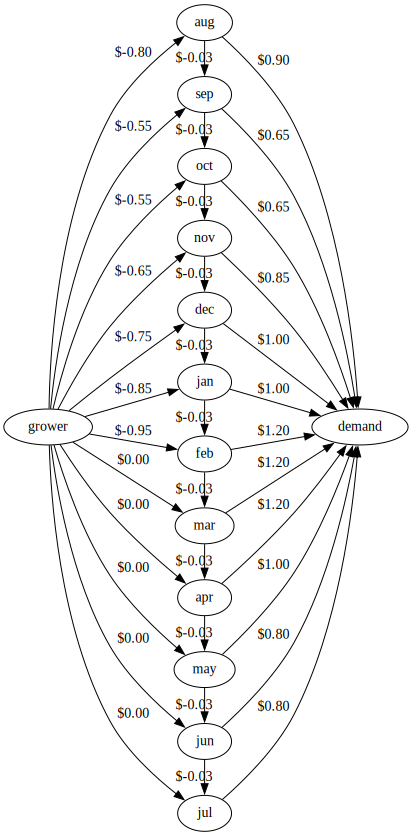

In [13]:
# Visualize the grocery network
dot = GVDigraph('grocery')
dot.attr(rankdir='LR')

dot.node('grower')

with dot.subgraph(name='months') as c:
    c.attr(rank='same')
    for month in months:
        c.node(month)

dot.node('demand')

for e in grocery_edges:
    dot.edge(e["from"], e["to"], label=f"${e['weight']:.2f}")

dot

In [14]:
# Solve (maximize profit)
result_grocery = runNetworkFlow(grocery_vertices, grocery_edges, maximize=True)

print(result_grocery[0])  # Optimal profit
print("\nKey flows:")
for edge_desc, flow in result_grocery[1:]:
    if flow > 100:  # Only show significant flows (> 100 kg)
        print(f"{edge_desc:<40} {flow:10.1f} kg")

optimal value: 31775.0

Key flows:
purchase (grower → aug)                     10000.0 kg
purchase (grower → sep)                     15000.0 kg
purchase (grower → oct)                     65000.0 kg
purchase (grower → nov)                     15000.0 kg
purchase (grower → dec)                      9000.0 kg
storage (oct → nov)                         50000.0 kg
storage (nov → dec)                         50000.0 kg
storage (dec → jan)                         46000.0 kg
storage (jan → feb)                         36000.0 kg
storage (feb → mar)                         26000.0 kg
storage (mar → apr)                         16000.0 kg
storage (apr → may)                          7000.0 kg
sales (aug → demand)                        10000.0 kg
sales (sep → demand)                        15000.0 kg
sales (oct → demand)                        15000.0 kg
sales (nov → demand)                        15000.0 kg
sales (dec → demand)                        13000.0 kg
sales (jan → demand)          

----

## Summary: Two Approaches

We've seen two ways to solve network flow problems:

1. **Explicit constraint building** (recommended for learning):
   - Build constraint matrices row by row
   - Clear understanding of each constraint
   - Good for homework and exams

2. **Generic solver** (advanced, optional):
   - Write functions that work for any network
   - Reusable code
   - Good for quickly solving many similar problems

For your assignment, use approach #1. Approach #2 is here for those interested in
seeing how to make code more general and reusable.